## Solve a life-cycle consumption/saving problem under perfect/subjective risk perception

- This notebook reproduces the life cycle consumption model by Gourinchas and Parker 2002 with the subjective belief formation about income risks
  - Preference/income process

      - CRRA utility 
      - No bequest motive (different from the original model)
      - During work: labor income risk: permanent + MA(1)/persistent/transitory + unemployment 
       - A constant growth rate of permanent income over the life cycle
        - it is subject to aggregate shock
      - During retirement: no risk
  - Belief formation
      - all state variables are obsersable: permanent income, ma(1) shock or the persistent shock
      - what's not perfectly known is the size and nature of the risks 
      - Perfect understanding case
      - Benchmark case without perfect understanding
         - individual observe past income realizations
         - subjectively determine the degree of persistence or the ma(1) coefficient 
         - form the best guess of income volatility using past experience, i.e. unexplained residuals  
      - Extenstion 0 
         - adding aggregate risks, and agents need to learn about the growth rate using cross-sectional experiences
         - so subjectively determine the cross-sectional correlation
         - form the best guess and the corresponding uncertainty based on the attribution
         
      - Extenstion 1
         - persistence attribution is assymmetric: determined by realized income shocks 
         - correlation attribution is assymetric: determined by realized income shocks 

In [1]:
import numpy as np
import pandas as pd
from quantecon.optimize import brent_max, brentq
from interpolation import interp, mlinterp
from scipy import interpolate
import numba as nb
from numba import njit, float64, int64, boolean, jitclass
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import MarkovChain
import quantecon as qe 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
## figure plotting configurations

mp.rc('xtick', labelsize=14) 
mp.rc('ytick', labelsize=14) 

fontsize = 14
legendsize = 12

## The Model Class and Solver

In [3]:
lc_data = [
    ('ρ', float64),              # utility parameter CRRA
    ('β', float64),              # discount factor
    ('R',float64),               # Nominal interest rate factor 
    ('P', float64[:, :]),        # transition probs for z_t, a persistent (macro) state  x
    ('z_val', float64[:]),       # values of z, grid values for the continous (macro) persistent state    x
    #('a_s', float64),           # preference volatility        x 
    #('sigma_s', float64),       # loading of macro state to preference    x
    ('sigma_n', float64),        # permanent shock volatility              x
    ('x',float64),               # MA(1) coefficient, or essentially the autocorrelation coef of non-persmanent income
    ('sigma_eps', float64),      # transitory shock volatility
    ('U',float64),               # the probability of being unemployed    * 
    ('b_y', float64),            # loading of macro state to income        x 
    ('s_grid', float64[:]),      # Grid over savings
    ('eps_grid', float64[:]),    # Grid over savings
    ('n_shk_draws', float64[:]), ## Draws of permanent income shock 
    ('eps_shk_draws', float64[:]), # Draws of MA/transitory income shocks 
    ('ue_shk_draws',boolean[:]), # Draws of unemployment shock 
    #('ζ_draws', float64[:])     # Draws of preference shock ζ for MC
    ('T',int64),                 # years of work                          *   
    ('L',int64),                 # years of life                          * 
    ('G',float64),               # growth rate of permanent income    *
    ('theta',float64),           ## extrapolation parameter 
    ('shock_draw_size',int64)    ## nb of points drawn for shocks 
]

In [15]:
@jitclass(lc_data)
class LifeCycle:
    """
    A class that stores primitives for the life cycle consumption problem.
    """

    def __init__(self,
                 ρ = 2,     ## relative risk aversion  
                 β = 0.96,  ## discount factor
                 P = np.array([(0.9, 0.1),
                             (0.1, 0.9)]),   ## transitory probability of stochastical state z
                 z_val = np.array([1.0,2.0]), 
                 sigma_n = 0.01,     ## size of permanent income shocks
                 #a_s = 0.02,        ## size of the taste shock  
                 #b_s = 0.0,         ## coefficient of pandemic state on taste 
                 x = 0.9,            ## MA(1) coefficient of non-permanent inocme shocks
                 sigma_eps = 0.03,     ## size of transitory income risks
                 U = 0.0,           ## unemployment risk probability (0-1)
                 b_y = 0.0,         ## loading of macro state on income  
                 R = 1.03,           ## interest factor 
                 T = 40,             ## work age, from 25 to 65
                 L = 60,             ## life length 85
                 G = 1.00,            ## growth rate of permanent income 
                 shock_draw_size = 20,
                 grid_max = 2.5,
                 grid_size = 50,
                 seed = 12343,
                 theta = 2):

        np.random.seed(seed)  # arbitrary seed

        self.ρ, self.β = ρ, β
        self.R = R 
        self.P, self.z_val = P, z_val
        self.G = G
        self.T,self.L = T,L
        
        self.sigma_n = sigma_n
        self.x = x
        self.sigma_eps = sigma_eps
        self.b_y = b_y
        
        ## shocks 
        self.shock_draw_size = shock_draw_size
        self.n_shk_draws = sigma_n*np.random.randn(shock_draw_size)-sigma_n**2/2
        self.eps_shk_draws = sigma_eps*np.random.randn(shock_draw_size)-sigma_eps**2/2
        self.ue_shk_draws = np.random.uniform(0,1,shock_draw_size)<U
        
        ## ma(1) shock grid 
        lb_sigma_ϵ = -sigma_eps**2/2-2*sigma_eps
        ub_sigma_ϵ = -sigma_eps**2/2+2*sigma_eps
        
        self.eps_grid = np.linspace(lb_sigma_ϵ,ub_sigma_ϵ,grid_size)
        ## saving grid
        self.s_grid = np.exp(np.linspace(np.log(1e-6), np.log(grid_max), grid_size))
       
       
        ## extrapolaton coefficient, i.e. higher theta, higher asymmetric response
        self.theta = theta
        
        # Test stability assuming {R_t} is IID and adopts the lognormal
        # specification given below.  The test is then β E R_t < 1.
        #ER = np.exp(b_r + a_r**2 / 2)
        assert β * R < 1, "Stability condition failed."

    # Marginal utility
    def u_prime(self, c):
        return c**(-self.ρ)

    # Inverse of marginal utility
    def u_prime_inv(self, c):
        return c**(-1/self.ρ)

    #def ϕ(self, z, ζ):
    #    ## preference 
    #    return np.exp(self.sigma_s * ζ + (z*self.b_s))

    def Y(self, z, u_shk):
        ## u_shk here represents the cumulated MA shock, for instance, for ma(1), u_shk = phi eps_(t-1) + eps_t
        ## income 
        return np.exp(u_shk + (z * self.b_y))
    
    def Γ(self,n_shk):
        return np.exp(n_shk)
    
    def reset(self):
        self.__init__()

In [16]:
@njit
def K(aϵ_in, σ_in, lc):
    """
    The Coleman--Reffett operator for the life-cycle consumption problem,
    using the endogenous grid method.

        * lc is an instance of life cycle model
        * σ_in is a n1 x n2 x n3 dimension consumption policy 
          * n1 = dim(s), n2 = dim(eps), n3 = dim(z)
        * aϵ_in is the same sized grid points of the three state variable 
        * aϵ_in[:,j,z] is the vector of asset grids corresponding to j-th grid of eps and z-th grid of z 
        * σ_in[i,j,z] is consumption at aϵ_in[i,j,z]
    """

    # Simplify names
    u_prime, u_prime_inv = lc.u_prime, lc.u_prime_inv
    R, ρ, P, β = lc.R, lc.ρ, lc.P, lc.β
    z_val = lc.z_val
    s_grid,eps_grid = lc.s_grid,lc.eps_grid
    n_shk_draws, eps_shk_draws, ue_shk_draws= lc.n_shk_draws, lc.eps_shk_draws, lc.ue_shk_draws
    Y = lc.Y
    ####################
    ρ = lc.ρ
    Γ = lc.Γ
    G = lc.G
    x = lc.x
    ###################
    
    n = len(P)

    # Create consumption function by linear interpolation
    ########################################################
    σ = lambda a,ϵ,z: mlinterp((aϵ_in[:,0,z],eps_grid),σ_in[:,:,z], (a,ϵ)) 
    ########## need to replace with multiinterp 

    # Allocate memory
    σ_out = np.empty_like(σ_in)  ## grid_size_s X grid_size_ϵ X grid_size_z

    # Obtain c_i at each s_i, z, store in σ_out[i, z], computing
    # the expectation term by Monte Carlo
    for i, s in enumerate(s_grid):
        for j, eps in enumerate(eps_grid):
            for z in range(n):
                # Compute expectation
                Ez = 0.0
                for z_hat in range(n):
                    z_val_hat = z_val[z_hat]
                    for eps_shk in eps_shk_draws:
                        for ue_shk in ue_shk_draws:
                            for n_shk in n_shk_draws:
                                Γ_hat = Γ(n_shk) 
                                u_shk = x*eps+eps_shk
                                Y_hat = Y(z_val_hat,u_shk)*(1-ue_shk) ## conditional on being employed 
                                c_hat = σ(R/(G*Γ_hat) * s + Y_hat,eps_shk,z_hat)
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)
                                Ez += utility * P[z, z_hat]
                Ez = Ez / (len(n_shk_draws)*len(eps_shk_draws)*len(ue_shk_draws))
                σ_out[i, j, z] =  u_prime_inv(β * R* Ez)

    # Calculate endogenous asset grid
    aϵ_out = np.empty_like(σ_out)
    
    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            aϵ_out[:,j,z] = s_grid + σ_out[:,j,z]

    # Fixing a consumption-asset pair at (0, 0) improves interpolation
    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            σ_out[0,j,z] = 0.0
            aϵ_out[0,j,z] = 0.0

    return aϵ_out, σ_out

In [17]:
@njit
def extrapolate(theta,
                x,
                eps_shk):
    """
    extrapolation function from realized eps_shk from unbiased risk x to the subjective risk x_sub
    x_sub = x when eps_shk = 0  
    """
    if x ==0.0:
        alpha=0.0
    else:
        alpha=np.log((1-x)/x) ## get the alpha for unbiased x
    x_sub = 1/(1+np.exp(alpha-theta*eps_shk))
    return x_sub

In [37]:
@njit
def K_br(aϵ_in, σ_in, lc):
    """
    UNDER BOUNDED RATIONALITY assumption
    The Coleman--Reffett operator for the life-cycle consumption problem. 
    using the endogenous grid method.

        * lc is an instance of life cycle model
        * σ_in is a n1 x n2 x n3 dimension consumption policy 
          * n1 = dim(s), n2 = dim(eps), n3 = dim(z)
        * aϵ_in is the same sized grid points of the three state variable 
        * aϵ_in[:,j,z] is the vector of asset grids corresponding to j-th grid of eps and z-th grid of z 
        * σ_in[i,j,z] is consumption at aϵ_in[i,j,z]
    """

    # Simplify names
    u_prime, u_prime_inv = lc.u_prime, lc.u_prime_inv
    R, ρ, P, β = lc.R, lc.ρ, lc.P, lc.β
    z_val = lc.z_val
    s_grid,eps_grid = lc.s_grid,lc.eps_grid
    n_shk_draws, eps_shk_draws, ue_shk_draws= lc.n_shk_draws, lc.eps_shk_draws, lc.ue_shk_draws
    Y = lc.Y
    ####################
    ρ = lc.ρ
    Γ = lc.Γ
    G = lc.G
    x = lc.x
    theta = lc.theta 
    sigma_eps = lc.sigma_eps
    eps_mean = -sigma_eps**2/2
    ###################
    
    n = len(P)

    # Create consumption function by linear interpolation
    ########################################################
    σ = lambda a,ϵ,z: mlinterp((aϵ_in[:,0,z],eps_grid),σ_in[:,:,z], (a,ϵ)) 
    ########## need to replace with multiinterp 

    # Allocate memory
    σ_out = np.empty_like(σ_in)  ## grid_size_s X grid_size_ϵ X grid_size_z

    # Obtain c_i at each s_i, z, store in σ_out[i, z], computing
    # the expectation term by Monte Carlo
    for i, s in enumerate(s_grid):
        for j, eps in enumerate(eps_grid):
            ##############################################################
            #x_sj = extrapolate(theta,
            #                   lc.x,
            #                   eps-eps_mean) ## sj: subjective 
            sigma_eps_sj = 0.05*np.sqrt((eps-eps_mean)**2)+0.95*lc.sigma_eps
            np.random.seed(166789)
            eps_shk_draws_sj = sigma_eps_sj*np.random.randn(lc.shock_draw_size)-sigma_eps_sj**2/2
            #############################################################
            for z in range(n):
                # Compute expectation
                Ez = 0.0
                for z_hat in range(n):
                    z_val_hat = z_val[z_hat]
                    ################################
                    for eps_shk in eps_shk_draws_sj:
                        ############################
                        for ue_shk in ue_shk_draws:
                            for n_shk in n_shk_draws:
                                Γ_hat = Γ(n_shk) 
                                ###############
                                u_shk = x*eps+eps_shk
                                ####################
                                Y_hat = Y(z_val_hat,u_shk)*(1-ue_shk) ## conditional on being employed 
                                c_hat = σ(R/(G*Γ_hat) * s + Y_hat,eps_shk,z_hat)
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)
                                Ez += utility * P[z, z_hat]
                Ez = Ez / (len(n_shk_draws)*len(eps_shk_draws_sj)*len(ue_shk_draws))
                σ_out[i, j, z] =  u_prime_inv(β * R* Ez)

    # Calculate endogenous asset grid
    aϵ_out = np.empty_like(σ_out)
    
    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            aϵ_out[:,j,z] = s_grid + σ_out[:,j,z]

    # Fixing a consumption-asset pair at (0, 0) improves interpolation
    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            σ_out[0,j,z] = 0.0
            aϵ_out[0,j,z] = 0.0

    return aϵ_out, σ_out

In [19]:
def solve_model_backward_iter(model,        # Class with model information
                              aϵ_vec,        # Initial condition for assets and MA shocks
                              σ_vec,        # Initial condition for consumption
                              #tol=1e-6,
                              #max_iter=2000,
                              #verbose=True,
                              #print_skip=50
                              br = False):

    # Set up loop
    #i = 0
    #error = tol + 1

    ## memories for life-cycle solutions 
    n_grids1 = σ_vec.shape[0]
    n_grids2 =σ_vec.shape[1]
    n_z = len(model.P)                       
    aϵs_new =  np.empty((model.T,n_grids1,n_grids2,n_z),dtype = np.float64)
    σs_new =  np.empty((model.T,n_grids1,n_grids2,n_z),dtype = np.float64)
    
    aϵs_new[0,:,:,:] = aϵ_vec
    σs_new[0,:,:,:] = σ_vec
    
    for i in range(model.T-1):
        print(f"at work age of "+str(model.T-i))
        aϵ_vec_next, σ_vec_next = aϵs_new[i,:,:,:],σs_new[i,:,:,:]
        if br==False:
            aϵ_new, σ_new = K(aϵ_vec_next, σ_vec_next, model)
        elif br==True:
            aϵ_new, σ_new = K_br(aϵ_vec_next, σ_vec_next, model)
        aϵs_new[i+1,:,:,:] = aϵ_new
        σs_new[i+1,:,:,:] = σ_new
    
    #while i < max_iter and error > tol:
    #    a_new, σ_new = K(a_vec, σ_vec, model)
    #    error = np.max(np.abs(σ_vec - σ_new))
    #    i += 1
    #    if verbose and i % print_skip == 0:
    #        print(f"Error at iteration {i} is {error}.")
    #    a_vec, σ_vec = np.copy(a_new), np.copy(σ_new)

    #if i == max_iter:
    #    print("Failed to converge!")

    #if verbose and i < max_iter:
    #    print(f"\nConverged in {i} iterations.")

    return aϵs_new, σs_new

In [20]:
def policyfunc(lc,
               a_star,
               σ_star,
               discrete = True):
    """
     * ifp is an instance of IFP
        * a_star is the endogenous grid solution
        * σ_star is optimal consumption on the grid    
    """
    if discrete==True:
        # Create consumption function by linear interpolation
        σ =  lambda a, z_idx: interp(a_star[:, z_idx], σ_star[:, z_idx], a) 
    else:
        # get z_grid 
        z_val = lc.z_val 

        # Create consumption function by linear interpolation
        a = a_star[:,0]                                ## aseet grid 
        σ =  interpolate.interp2d(a, z_val, σ_star.T) 
    
    return σ

In [21]:
def policyfuncMA(lc,
                 aϵ_star,
                 σ_star):
    """
     * ifp is an instance of IFP
        * aϵ_star is the endogenous grid solution
        * σ_star is optimal consumption on the grid    
    """
   
   # get z_grid 
    s_grid = lc.s_grid
    
    # Create consumption function by linear interpolation
    a = aϵ_star[:,0]         
    σ =  interpolate.interp2d(a, s_grid, σ_star.T) 
    
    return σ

## Solve the model for some consumption from the last period 

In [22]:
## this is the retirement consumption policy 

def policyPF(β,
             ρ,
             R,
             T,
             L):
    c_growth = β**(1/ρ)*R**(1/ρ-1)
    return (1-c_growth)/(1-c_growth**(L-T))

In [23]:
## stochastical parameters 

U = 0.1
sigma_n = np.sqrt(0.02) # permanent 
sigma_eps = np.sqrt(0.09) # transitory 

## other parameters 

ρ = 2
R = 1.03
β = 0.96
x = 0.50
theta = 1.1

## no macro state
b_y = 0.00

In [24]:
## intialize 

lc = LifeCycle(sigma_n=sigma_n,
               sigma_eps = sigma_eps,
               U=U,
               ρ=ρ,
               R=R,
               β=β,
               x=x,
               theta=theta,
               b_y=b_y)

In [25]:
# Initial the retirement consumption policy of σ = consume all assets

#mpc_ret = policyPF(lc.β,
#                   lc.ρ,
#                   lc.R,
#                   lc.T,
#                   lc.L) 
#ratio = mpc_ret/(1-mpc_ret)


## initial consumption functions 

k = len(lc.s_grid)
k2 =len(lc.eps_grid)

n = len(lc.P)
σ_init = np.empty((k,k2,n))
a_init = np.empty((k,k2,n))

for z in range(n):
    for j in range(k2):
        σ_init[:,j,z] = 2*lc.s_grid
        a_init[:,j,z] =  2*lc.s_grid

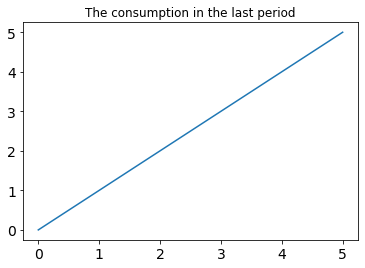

In [26]:
plt.title('The consumption in the last period')
plt.plot(σ_init[:,1,1],a_init[:,1,1])

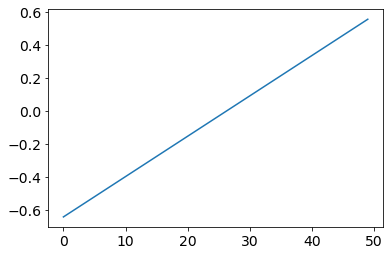

In [27]:
plt.plot(lc.eps_grid)

In [28]:
## solve the model for a range of ma(1) coefficients

x_ls = [0.0]
as_stars =[]
σs_stars = []
for i,x in enumerate(x_ls):
    lc.x = x
    as_star, σs_star = solve_model_backward_iter(lc,
                                                 a_init,
                                                 σ_init)
    as_stars.append(as_star)
    σs_stars.append(σs_star)

at work age of 40
at work age of 39
at work age of 38
at work age of 37
at work age of 36
at work age of 35
at work age of 34
at work age of 33
at work age of 32
at work age of 31
at work age of 30
at work age of 29
at work age of 28
at work age of 27
at work age of 26
at work age of 25
at work age of 24
at work age of 23
at work age of 22
at work age of 21
at work age of 20
at work age of 19
at work age of 18
at work age of 17
at work age of 16
at work age of 15
at work age of 14
at work age of 13
at work age of 12
at work age of 11
at work age of 10
at work age of 9
at work age of 8
at work age of 7
at work age of 6
at work age of 5
at work age of 4
at work age of 3
at work age of 2


In [29]:
as_star.shape

(40, 50, 50, 2)

### Plot interpolated policy functions

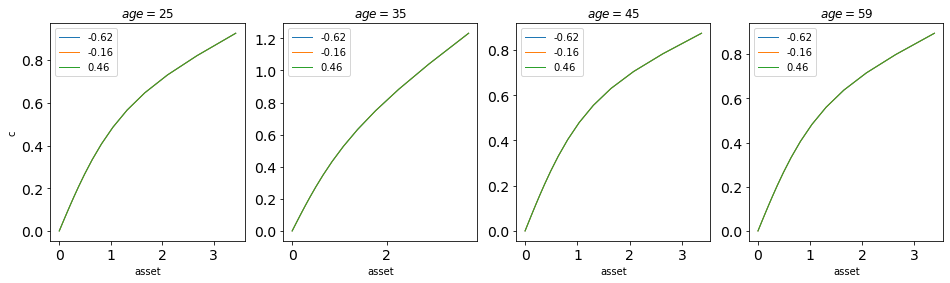

In [30]:
## plot c func at different age /asset grid

ages  = [25,35,45,59]
n_sub = len(ages)
eps_ls = [1,20,45]

as_star = as_stars[0]
σs_star =σs_stars[0]


fig,axes = plt.subplots(1,n_sub,figsize=(4*n_sub,4))

for x,age in enumerate(ages):
    i = lc.T-age
    for y,eps in enumerate(eps_ls):
        axes[x].plot(as_star[i,:,eps,0],
                     σs_star[i,:,eps,0],
                     label = str(round(lc.eps_grid[eps],2)),
                     lw=1)
    axes[x].legend()
    axes[x].set_xlabel('asset')
    axes[0].set_ylabel('c')
    axes[x].set_title(r'$age={}$'.format(age))

In [31]:
## interpolate consumption function on continuous s/eps grid 

σs_list = []

for i in range(lc.T):
    this_σ= policyfuncMA(lc,
                         as_star[i,:,:,0],
                         σs_star[i,:,:,0])
    σs_list.append(this_σ)

Text(0, 0.5, 'ma income shock')

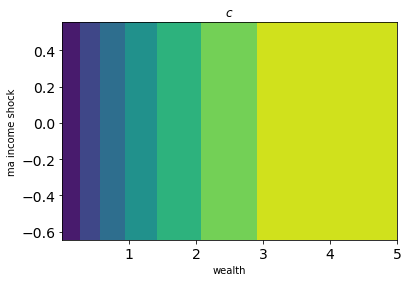

In [32]:
## plot contour for policy function 

a_grid = np.linspace(0.00001,5,20)
eps_grid = lc.eps_grid
aa,epss = np.meshgrid(a_grid,
                      eps_grid)

σ_this = σs_list[10]
c_stars = σ_this(a_grid,
                 eps_grid)

cp = plt.contourf(aa,epss,
                  c_stars)
plt.title(r'$c$')
plt.xlabel('wealth')
plt.ylabel('ma income shock')

In [33]:
σs_star.shape

(40, 50, 50, 2)

Text(0.5, 0.92, 'consumption at a certain age')

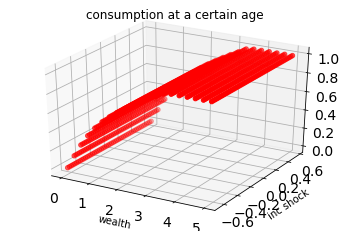

In [34]:
## plot 3d consumption function 
#age,asset,inc_shk =σs_star[:,:,:,0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(aa, epss, c_stars, zdir='z', c= 'red')
ax.set_xlabel('wealth')
ax.set_ylabel('inc shock')
ax.set_title('consumption at a certain age')
#plt.savefig("demo.png")

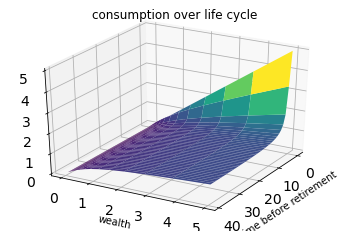

In [35]:
## plot 3d functions over life cycle 

ages = np.array(range(as_star.shape[0]))
#ages_id = lc.T-ages
asset = as_star[0,:,10,0]
xx, yy = np.meshgrid(ages, asset)
c_stars = σs_star[:,:,10,0].T

fig = plt.figure()
ax = fig.add_subplot(111, 
                     projection='3d')
dem3d = ax.plot_surface(xx,
                        yy,
                        c_stars,
                        rstride=1, 
                        cstride=1,
                        cmap='viridis', 
                        edgecolor='none'
                       )
ax.set_title('consumption over life cycle')
ax.set_xlabel('time before retirement')
ax.set_ylabel('wealth')
ax.view_init(30, 30)

#### Different ma persistence

Text(0.5, 1.0, 'work age$=30$')

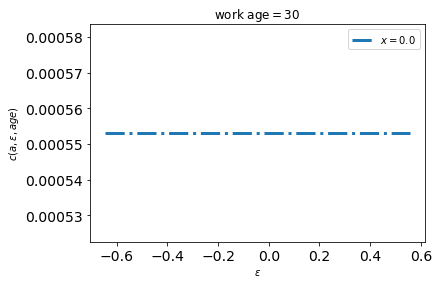

In [36]:
at_age = 30
at_asset_id = 20

for i,x in enumerate(x_ls):
    this_σs_star = σs_stars[i]
    plt.plot(lc.eps_grid,
             this_σs_star[lc.T-at_age,at_asset_id,:,0],
             '-.',
             label = r'$x={}$'.format(x),
             lw=3)
plt.legend(loc=0)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$c(a,\epsilon,age)$')
plt.title(r'work age$={}$'.format(at_age))

In [38]:
## solve for subjective agent 

as_br, σs_br = solve_model_backward_iter(lc,
                                         a_init,
                                         σ_init,
                                         br = True) ## bounded rationality is true 

at work age of 40
at work age of 39
at work age of 38
at work age of 37
at work age of 36
at work age of 35
at work age of 34
at work age of 33
at work age of 32
at work age of 31
at work age of 30
at work age of 29
at work age of 28
at work age of 27
at work age of 26
at work age of 25
at work age of 24
at work age of 23
at work age of 22
at work age of 21
at work age of 20
at work age of 19
at work age of 18
at work age of 17
at work age of 16
at work age of 15
at work age of 14
at work age of 13
at work age of 12
at work age of 11
at work age of 10
at work age of 9
at work age of 8
at work age of 7
at work age of 6
at work age of 5
at work age of 4
at work age of 3
at work age of 2


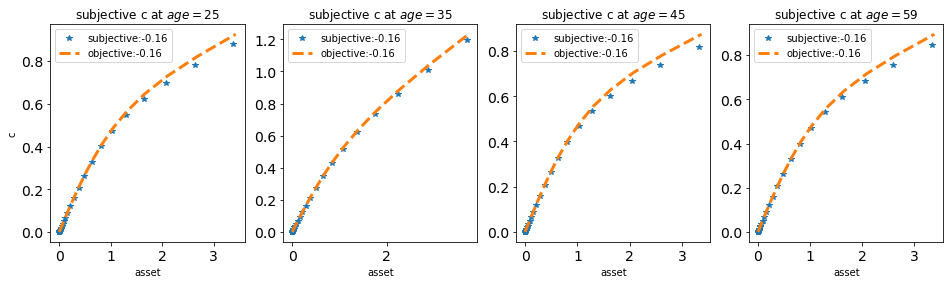

In [39]:
## compare subjective and objective model 
ages  = [25,35,45,59]
n_sub = len(ages)
eps_ls = [20]

fig,axes = plt.subplots(1,n_sub,figsize=(4*n_sub,4))

for x,age in enumerate(ages):
    i = lc.T-age
    for y,eps in enumerate(eps_ls):
        axes[x].plot(as_br[i,:,eps,0],
                     σs_br[i,:,eps,0],
                     '*',
                     label = 'subjective:'+str(round(lc.eps_grid[eps],2)),
                     lw=3)
        axes[x].plot(as_star[i,:,eps,0],
                     σs_star[i,:,eps,0],
                     '--',
                     label ='objective:'+str(round(lc.eps_grid[eps],2)),
                     lw=3)
    axes[x].legend()
    axes[x].set_xlabel('asset')
    axes[0].set_ylabel('c')
    axes[x].set_title(r'subjective c at $age={}$'.format(age))

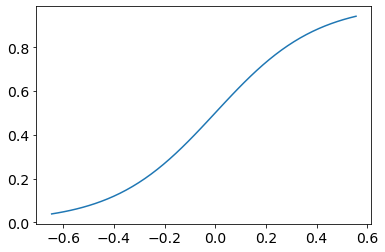

In [40]:
x_sj = extrapolate(5, 
                   lc.x,
                   lc.eps_grid) ## sj: subjective 

plt.plot(lc.eps_grid,x_sj)

Text(0.5, 1.0, 'subjectiv c at work age$=35$')

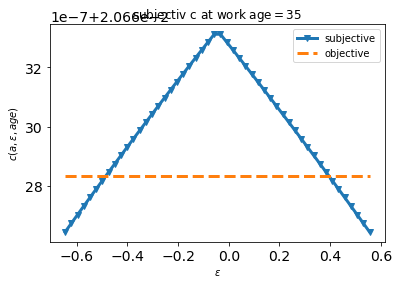

In [43]:
at_age = 35
at_asset_id = 32

plt.plot(lc.eps_grid,
         σs_br[lc.T-at_age,at_asset_id,:,0],
             'v-',
             label = 'subjective',
             lw=3)
plt.plot(lc.eps_grid,
         σs_star[lc.T-at_age,at_asset_id,:,0],
         '--',
         label='objective',
         lw=3)
plt.legend(loc=0)
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$c(a,\epsilon,age)$')
plt.title(r'subjectiv c at work age$={}$'.format(at_age))

### Adding a Markov/persistent state 

In [217]:
## initialize another 
lc_ρ = LifeCycle()

## set the macro state loading to be positive
lc_ρ.b_y = 1.0
lc_ρ.x = 0.0 ## shut down ma(1)

In [223]:
## solve the model for different persistence 

ρ_ls = [0.99]
as_stars_ρ=[]
σs_stars_ρ = []

for i, ρ in enumerate(ρ_ls):
    
    ## tauchenize an ar1
    σ = 0.18
    constant = 0.00

    mc = qe.markov.approximation.tauchen(ρ, σ, b=constant, m=3, n=7)
    #z_ss_av = constant/(1-ρ)
    #z_ss_sd = σ*np.sqrt(1/(1-ρ**2))
    
    ## feed the model with a markov matrix of macro state 
    lc_ρ.z_val, lc_ρ.P = mc.state_values, mc.P
    
    ## initial guess
    k = len(lc_ρ.s_grid)
    k2 =len(lc_ρ.eps_grid)
    n = len(lc_ρ.P)
    
    σ_init_ρ = np.empty((k,k2,n))
    a_init_ρ = np.empty((k,k2,n))

    for z in range(n):
        for j in range(k2):
            σ_init_ρ[:,j,z] = 2*lc_ρ.s_grid
            a_init_ρ[:,j,z] = 2*lc_ρ.s_grid
    
    ## solve the model 
    as_star_ρ, σs_star_ρ = solve_model_backward_iter(lc_ρ,
                                                     a_init_ρ,
                                                     σ_init_ρ)
    as_stars_ρ.append(as_star_ρ)
    σs_stars_ρ.append(σs_star_ρ)

at work age of 40
at work age of 39
at work age of 38
at work age of 37
at work age of 36
at work age of 35
at work age of 34
at work age of 33
at work age of 32
at work age of 31
at work age of 30
at work age of 29
at work age of 28
at work age of 27
at work age of 26
at work age of 25
at work age of 24
at work age of 23
at work age of 22
at work age of 21
at work age of 20
at work age of 19
at work age of 18
at work age of 17
at work age of 16
at work age of 15
at work age of 14
at work age of 13
at work age of 12
at work age of 11
at work age of 10
at work age of 9
at work age of 8
at work age of 7
at work age of 6
at work age of 5
at work age of 4
at work age of 3
at work age of 2


In [222]:
## solve the model for different persistence 

ρ_ls = [0.95,0.98]
as_stars_ρ=[]
σs_stars_ρ = []

for i, ρ in enumerate(ρ_ls):
    
    ## tauchenize an ar1
    σ = 0.18
    constant = 0.00

    mc = qe.markov.approximation.tauchen(ρ, σ, b=constant, m=3, n=7)
    #z_ss_av = constant/(1-ρ)
    #z_ss_sd = σ*np.sqrt(1/(1-ρ**2))
    
    ## feed the model with a markov matrix of macro state 
    lc_ρ.z_val, lc_ρ.P = mc.state_values, mc.P
    
    ## initial guess
    k = len(lc_ρ.s_grid)
    k2 =len(lc_ρ.eps_grid)
    n = len(lc_ρ.P)
    
    σ_init_ρ = np.empty((k,k2,n))
    a_init_ρ = np.empty((k,k2,n))

    for z in range(n):
        for j in range(k2):
            σ_init_ρ[:,j,z] = 2*lc_ρ.s_grid
            a_init_ρ[:,j,z] = 2*lc_ρ.s_grid
    
    ## solve the model 
    as_star_ρ, σs_star_ρ = solve_model_backward_iter(lc_ρ,
                                                     a_init_ρ,
                                                     σ_init_ρ)
    as_stars_ρ.append(as_star_ρ)
    σs_stars_ρ.append(σs_star_ρ)

at work age of 40


KeyboardInterrupt: 

In [58]:
## interpolate consumption function on continuous z grid 

σs_ag_list = []

for i in range(lc_ag.T):
    this_σ= policyfunc(lc_ag,
                   as_star_ag[i,:,:],
                   σs_star_ag[i,:,:],
                   discrete = False)
    σs_ag_list.append(this_σ)

Text(0, 0.5, 'macro state')

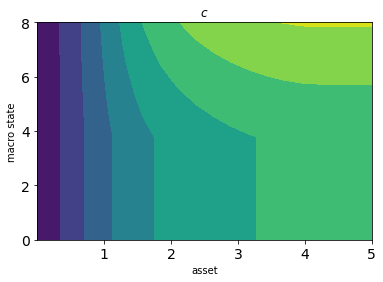

In [61]:
## plot contour for policy function 

a_grid = np.linspace(0.00001,5,20)
z_grid = np.linspace(0,8,20)
aa,zz = np.meshgrid(a_grid,z_grid)

σ_this = σs_ag_list[15]

c_stars = σ_this(a_grid,z_grid)

cp = plt.contourf(aa, zz,c_stars)
plt.title(r'$c$')
plt.xlabel('asset')
plt.ylabel('persistence state')

## Simulate a cross-sectionl history 

In [73]:
#@njit
def simulate_time_series(lc, σ, z_idx_seq, p_income,T=400):
    """
    Simulates a time series of length T for assets/consumptions, given optimal
    consumption/demand functions.
    * z_seq is a time path for {Z_t} recorded by index, instead of its numeric value

    """
    
    # Simulate the asset path
    a = np.zeros(T)+1e-4
    c  = np.empty_like(a)
    #c1 = np.empty_like(a)
    #c2 = np.empty_like(a)
    
    ## simulate histories
    ζ_sim = np.random.randn(T)
    η_sim = np.random.randn(T)
    
    
    R = lc.R
    z_val = lc.z_val ## values of the state 
    
    
    ## permanent income shocks
    
    Γs = p_income[1:]/p_income[:-1] 
    
    for t in range(T):
        z_idx = z_idx_seq[t]
        z = z_val[z_idx]    
        S = lc.ϕ(z,ζ_sim[t])
        Y = lc.Y(z, η_sim[t])
        c[t] = σ(a[t], z_idx)
        #c1[t],c2[t] = allocate(c[t], S = S) 
        #if t<T-1:
        #    a[t+1] = R/Γs[t] * (a[t] - c1[t]*p_vec[0]-c2[t]*p_vec[1]) + Y
        if t<T-1:
            a[t+1] = R/Γs[t] * (a[t] - c[t]) + Y
        
    ## multiply permanent income level 
    #c = c*p_income
    #c1 =c1*p_income
    #c2 = c2*p_income
    #a = a * p_income 
    
    return a,c

def simulate_time_series_new(lc, σ, z_seq, p_income, T=400):
    """
    Simulates a time series of length T for assets/consumptions, given optimal
    consumption/demand functions.

        * ifp is an instance of IFP
        * a_star is the endogenous grid solution
        * σ_star is optimal consumption on the grid
        * z_seq is a time path for {Z_t} recorded by its numeric value (different from the previous function)

    """
    
    # Simulate the asset path
    a = np.zeros(T)+1e-4
    c = np.empty_like(a)
    #c1 = np.empty_like(a)
    #c2 = np.empty_like(a)
    
    ## simulate histories
    ζ_sim = np.random.randn(T)
    η_sim = np.random.randn(T)
    
    
    R = lc.R
    #z_val = ifp.z_val ## values of the state 
    
    ## permanent income shocks
    
    Γs = p_income[1:]/p_income[:-1] 
    
    for t in range(T):
        z = z_seq[t] ## z values
        S = lc.ϕ(z,ζ_sim[t])
        Y = lc.Y(z, η_sim[t])
        c[t] = σ(a[t], z)
        #c1[t],c2[t] = allocate(c[t], S = S) 
        #if t<T-1:
        #    a[t+1] = R/Γs[t] * (a[t] - c1[t]*p_vec[0]-c2[t]*p_vec[1]) + Y
        if t<T-1:
            a[t+1] = R/Γs[t] * (a[t] - c[t]) + Y
        
    ## multiply permanent income level 
    #c = c*p_income
    #c1 =c1*p_income
    #c2 = c2*p_income
    #a = a * p_income 
    
    return a,c

## now, we simulate the time-series of a cross-sectional matrix of N agents 

#@njit
def simulate_distribution(lc, 
                          a_star, 
                          p_vec, 
                          σ_star,
                          z_mat, 
                          p_income_mat,
                          N = 3000, 
                          T = 400,
                          discrete = True):
    N_z, T_z = z_mat.shape
    
    assert N_z>=N and T_z >=T, 'history of the markov states are smaller than the simulated matrix'
    
    
    z_mat = z_mat[0:N,0:T]
    ## z_mat is a N_sim x T sized matrix that takes the simulated Markov states 
    a_mat = np.empty((N,T))
    c_mat = np.empty((N,T))
    #c1_mat = np.empty((N,T))
    #c2_mat = np.empty((N,T))
    
    ## get the policy function
    
    if discrete ==True:
        σ = policyfunc(lc,
                       a_star,
                       σ_star,
                       discrete = True)  ## interpolate for discrete z index 
        for i in range (N):
            a_mat[i,:],c_mat[i,:] = simulate_time_series(lc,
                                                         σ,
                                                         z_mat[i,:],
                                                         p_income_mat[i,:],
                                                         T = T)
    else:
        σ = policyfunc(lc,
                       a_star,
                       σ_star,
                       discrete = False) ## interpolate for continous z value 
        for i in range (N):
            a_mat[i,:],c_mat[i,:]= simulate_time_series_new(lc,
                                                            σ,
                                                            z_mat[i,:],
                                                            p_income_mat[i,:],
                                                            T = T)
            
    ## multiply permanent income level 
    #c_mat= np.multiply(c_mat,p_income_mat)
    #c1_mat = np.multiply(c1_mat,p_income_mat)
    #c2_mat = np.multiply(c2_mat,p_income_mat)
    #a_mat = np.multiply(a_mat,p_income_mat) 

    return a_mat,c_mat

In [74]:
## simulate a Markov sequence 

mc = MarkovChain(lc.P)

### Simulate history of Idiosyncratic Z states 
#### (For Z to be aggregate state. We can directly copy Z for different agents) 

## number of agents 

N = 1000
T = 25        ## simulated history of time period

z_idx_ts = mc.simulate(T, random_state=13274)
z_idx_mat = np.tile(z_idx_ts,(N,1))

In [75]:
## simulate a permanent income distributions 

@njit
def PerIncSimulate(T,
               sigma,
               init = 0.001):
    pshk_draws = sigma*np.random.randn(T)-sigma**2/2
    log_p_inc = np.empty(T)
    log_p_inc[0] = init
    for t in range(T-1):
        log_p_inc[t+1] = log_p_inc[t]+ pshk_draws[t+1]
    p_income = np.exp(log_p_inc)
    return p_income

## simulate histories of permanent income 

p_income_mat = np.empty((N,T))

for n in range(N):
    p_income_mat[n,:] = PerIncSimulate(T,
                                       sigma = lc.sigma_n,
                                       init = 0.0001)

In [78]:
## Simulate the distribution of consumption/asset (perfect understanding)

p_vec = (1,1) 
a_dist,c_dist = simulate_distribution(lc,
                                      a_bf_star,
                                      p_vec,
                                      σ_bf_star,
                                      z_idx_mat,
                                      p_income_mat,
                                      N = N,
                                      T = T,
                                      discrete = True)

NameError: name 'a_bf_star' is not defined

In [51]:
## aggregate history 

co_mat = np.multiply(c_dist,p_income_mat)  ## non-normalized consumption
lco_mat = np.log(co_mat)
lco_av = np.mean(lco_mat,axis = 0)

#p_av =  np.mean(p_income_mat,axis = 0)  
#lp_av = np.log(p_av)
lp_income_mat = np.log(p_income_mat)   ## permanent income level 
lp_av = np.mean(lp_income_mat,axis = 0)

#c_av = np.mean(c_dist,axis=0)
#lc_av = np.log(c_av)
lc_mat = np.log(c_dist)             ## normalized consumption
lc_av = np.mean(lc_mat,axis = 0) 

lc_sd = np.sqrt(np.diag(np.cov(lc_mat.T)))

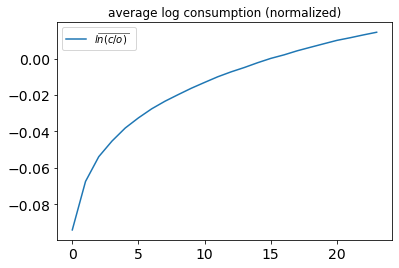

In [52]:
plt.title('average log consumption (normalized)')
plt.plot(lc_av[1:],label = r'$\widebar{ln(c/o)}$')
plt.legend(loc=2)

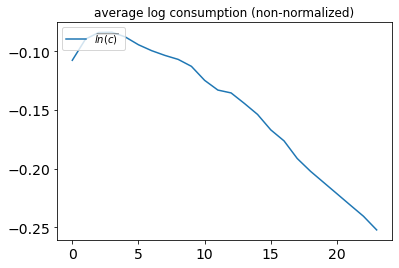

In [53]:
plt.title('average log consumption (non-normalized)')
plt.plot(lco_av[1:],label = r'$\widebar{ln(c)}$')
plt.legend(loc=2)

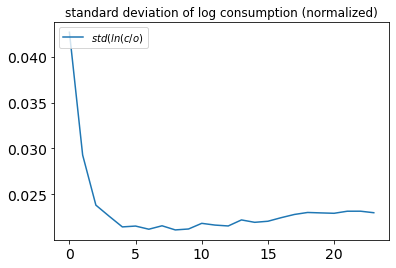

In [54]:
plt.title('standard deviation of log consumption (normalized)')
plt.plot(lc_sd[1:],label = r'$std(ln(c/o)$')
plt.legend(loc=2)

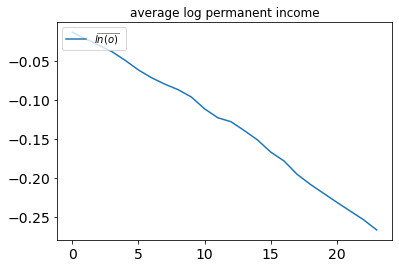

In [55]:
plt.title('average log permanent income')
plt.plot(lp_av[1:],label = r'$\widebar{ln(o)}$')
plt.legend(loc=2)

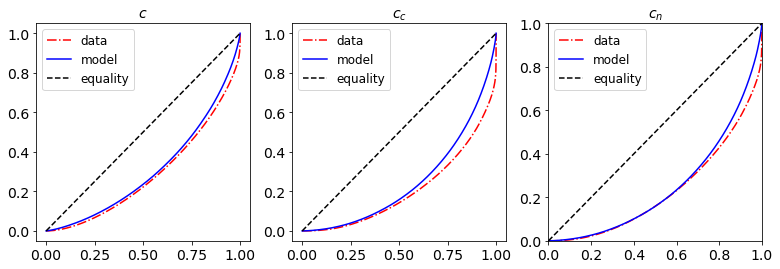

In [56]:
## get lorenz curve of the consumption inequality 

C_model = c_dist[:,-1]
C1_model = c1_dist[:,-1]
C2_model = c2_dist[:,-1]

## multiply by permanent income 
CO_model = np.multiply(c_dist[:,-1],p_income_mat[:,-1])
CO1_model = np.multiply(c1_dist[:,-1],p_income_mat[:,-1])
CO2_model = np.multiply(c2_dist[:,-1],p_income_mat[:,-1])

fc_m_vals, lc_m_vals = qe.lorenz_curve(CO_model)
fc1_m_vals, lc1_m_vals = qe.lorenz_curve(CO1_model)
fc2_m_vals, lc2_m_vals = qe.lorenz_curve(CO2_model)


fig, axs = plt.subplots(1,
                        3,
                        figsize=(13,4))

## total consumption 
axs[0].plot(fc_vals, lc_vals, 'r-.',label='data')
axs[0].plot(fc_m_vals, lc_m_vals, 'b-',label='model')
axs[0].plot(fc_vals, fc_vals, 'k--',label='equality')
axs[0].legend(fontsize=legendsize)
axs[0].set_title(r'$c$',fontsize=fontsize)
#plt.xlim([0,1])
#plt.ylim([0,1])

## conctact consumption 

## total consumption 
axs[1].plot(fc1_vals, lc1_vals, 'r-.',label='data')
axs[1].plot(fc1_m_vals, lc1_m_vals, 'b-',label='model')
axs[1].plot(fc1_vals, fc1_vals, 'k--',label='equality')
axs[1].legend(fontsize=legendsize)
axs[1].set_title(r'$c_c$',fontsize=fontsize)
#plt.xlim([0,1])
#plt.ylim([0,1])


## total consumption 
axs[2].plot(fc2_vals, lc2_vals, 'r-.',label='data')
axs[2].plot(fc2_m_vals, lc1_m_vals, 'b-',label='model')
axs[2].plot(fc2_vals, fc2_vals, 'k--',label='equality')
axs[2].legend(fontsize=legendsize)
axs[2].set_title(r'$c_n$',fontsize=fontsize)
plt.xlim([0,1])
plt.ylim([0,1])

plt.show()
fig.savefig('../graph/model/lorenz_c.jpg')

## Then, solve the model with the pandemic 



In [57]:
ifp.b_y = -0.1
ifp.b_s = -0.2

In [58]:
## Pandemic Markov 

## feed a markov tanchened from ar1
## these parameters are estimated from Covid19 cases per capita of all U.S. counties during the pandemic 

ρ, σ = (0.978,0.18)
constant = 0.13  
mc = qe.markov.approximation.tauchen(ρ, σ, b=constant, m=3, n=7)
z_ss_av = constant/(1-ρ)
z_ss_sd = σ*np.sqrt(1/(1-ρ**2))

## feed ifp with a markov matrix 
ifp.z_val, ifp.P = mc.state_values, mc.P

## some initial guesses 
k = len(ifp.s_grid)
n = len(ifp.P)
σ_init = np.empty((k, n))
for z in range(n):
    σ_init[:, z] = ifp.s_grid
a_init = np.copy(σ_init)

In [59]:
a_star, σ_star = solve_model_time_iter(ifp,a_init, σ_init)

Error at iteration 50 is 0.002146414780226813.
Error at iteration 100 is 0.0007843227956180199.
Error at iteration 150 is 0.00047768428625771797.
Error at iteration 200 is 0.0003346376274815377.
Error at iteration 250 is 0.00024637405251515254.
Error at iteration 300 is 0.0001857151048272332.
Error at iteration 350 is 0.00014212568494076372.
Error at iteration 400 is 0.00011003970810674613.
Error at iteration 450 is 8.602229155685315e-05.
Error at iteration 500 is 6.780360349101233e-05.
Error at iteration 550 is 5.382718559399091e-05.
Error at iteration 600 is 4.299909506899624e-05.
Error at iteration 650 is 3.453623319293886e-05.
Error at iteration 700 is 2.7869818949866065e-05.
Error at iteration 750 is 2.2581586592185232e-05.
Error at iteration 800 is 1.8360465712796703e-05.
Error at iteration 850 is 1.4972647404798423e-05.
Error at iteration 900 is 1.2240620717807182e-05.
Error at iteration 950 is 1.0028323529809313e-05.
Error at iteration 1000 is 8.230516299834179e-06.
Error at it

In [62]:
## interpolate consumption function on continuous z grid 
σ_= policyfunc(ifp,
               a_star,
               σ_star,
               discrete = False)

Text(0, 0.5, 'infection')

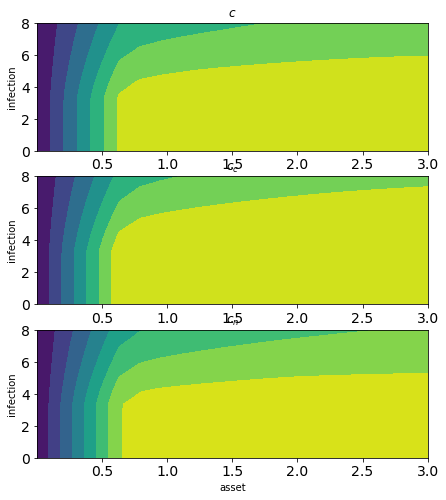

In [63]:
## plot contour for policy function 

a_grid = np.linspace(0.00001,3,20)
z_grid = np.linspace(0,8,20)
aa,zz = np.meshgrid(a_grid,z_grid)

c_stars = σ_(a_grid,z_grid)
c1_stars,c2_stars = allocate(c_stars,S = 1)

fig,ax = plt.subplots(3,1,figsize=(7,8))

cp1 = ax[0].contourf(aa, zz,c_stars)
ax[0].set_title(r'$c$')
ax[0].set_xlabel('asset')
ax[0].set_ylabel('infection')


cp2 = ax[1].contourf(aa, zz,c1_stars)
ax[1].set_title(r'$c_c$')
ax[1].set_xlabel('asset')
ax[1].set_ylabel('infection')


cp3 = ax[2].contourf(aa, zz,c2_stars)
ax[2].set_title(r'$c_n$')
ax[2].set_xlabel('asset')
ax[2].set_ylabel('infection')